# Predykcja Cen Samochodów - Analiza i Modelowanie

## Opis projektu
Projekt skupia się na predykcji cen samochodów używanych przy użyciu technik uczenia maszynowego. 
Obejmuje pełny pipeline od analizy eksploracyjnej przez preprocessing danych po trenowanie i ewaluację modeli.

## Struktura projektu:
1. **Wczytywanie i podstawowa analiza danych**
2. **Eksploracyjna analiza danych (EDA)**
3. **Czyszczenie danych**
4. **Preprocessing i feature engineering**
5. **Trenowanie modeli regresji**
6. **Wizualizacja wyników i podsumowanie**

## 1. Importy bibliotek

Importujemy wszystkie niezbędne biblioteki do analizy danych, wizualizacji i uczenia maszynowego.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## 2. Wczytywanie danych

Wczytujemy dane treningowe i testowe z plików CSV oraz wykonujemy podstawową inspekcję.

In [2]:
# Wczytywanie danych treningowych i testowych z osobnych plików
train_df = pd.read_csv('train-data.csv')
test_df = pd.read_csv('test-data.csv')

# Sprawdzenie kształtu danych
print("Kształt danych treningowych:", train_df.shape)
print("Kształt danych testowych:", test_df.shape)

train_df.head()


Kształt danych treningowych: (6019, 14)
Kształt danych testowych: (1234, 13)


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


## 3. Eksploracyjna Analiza Danych (EDA)

Podstawowa analiza danych treningowych obejmująca:
- Informacje o strukturze danych
- Sprawdzenie brakujących wartości  
- Typy danych
- Statystyki opisowe

In [3]:
# Podstawowe informacje o danych
print("PODSTAWOWE INFORMACJE O DANYCH")
print(f"Liczba wierszy: {train_df.shape[0]}")
print(f"Liczba kolumn: {train_df.shape[1]}")
print(f"Nazwy kolumn: {list(train_df.columns)}")

#Sprawdzenie brakujących danych
print("\nBRAKUJĄCE DANE")
missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0])

# Typy danych
print("\nTYPY DANYCH")
print(train_df.dtypes)

# Podstawowe statystyki dla kolumn numerycznych
print("\nSTATYSTYKI OPISOWE")
print(train_df.describe())

PODSTAWOWE INFORMACJE O DANYCH
Liczba wierszy: 6019
Liczba kolumn: 14
Nazwy kolumn: ['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'New_Price', 'Price']

BRAKUJĄCE DANE
Mileage         2
Engine         36
Power          36
Seats          42
New_Price    5195
dtype: int64

TYPY DANYCH
Unnamed: 0             int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

STATYSTYKI OPISOWE
        Unnamed: 0         Year  Kilometers_Driven        Seats        Price
count  6019.000000  6019.000000       6.019000e+03  5977.000000  6019.000000
mean   3009.000000  20

Kolumna z ceną: Price


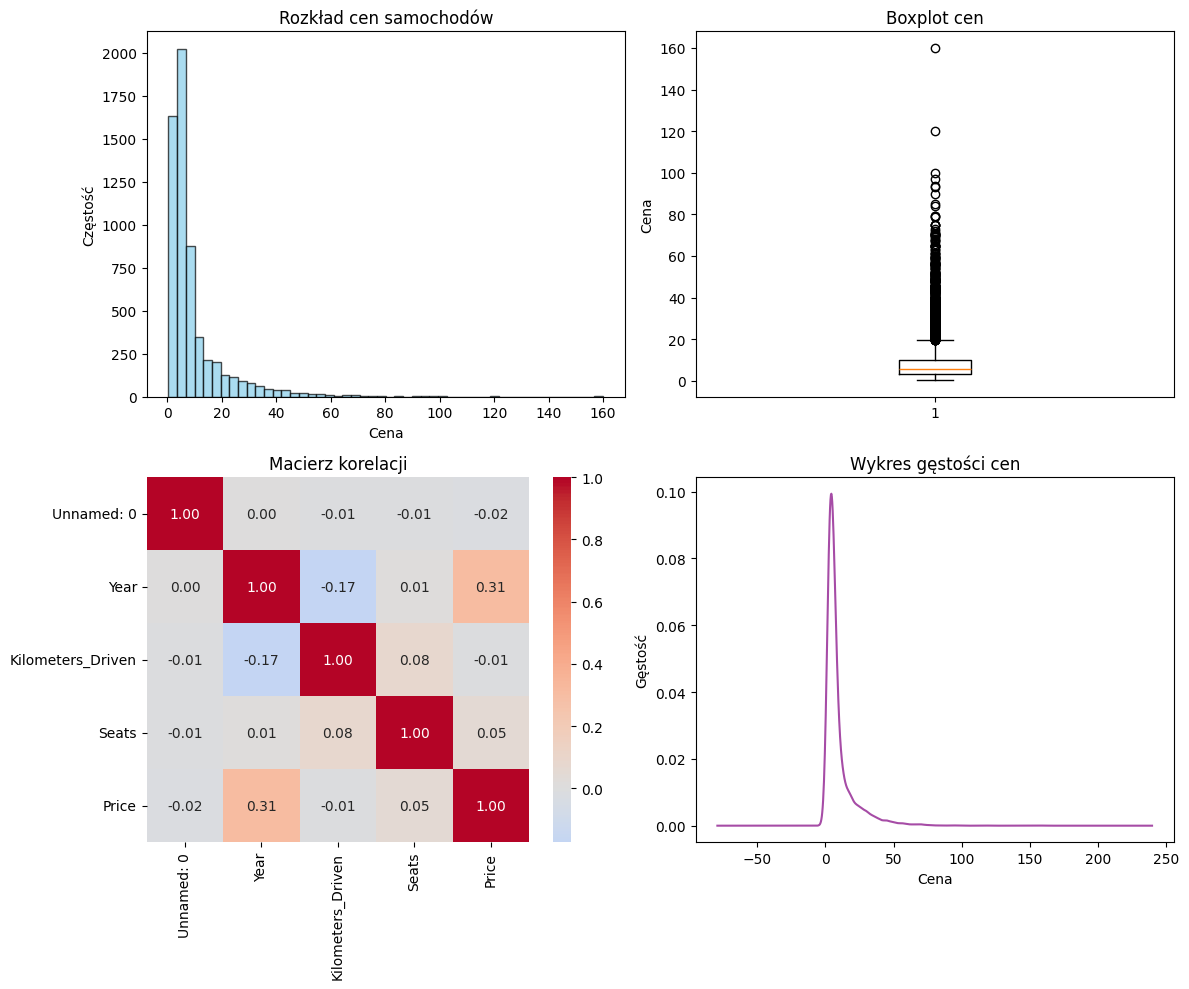


Podstawowe statystyki cen:
Średnia: 9.48
Mediana: 5.64
Min: 0.44
Max: 160.00


In [4]:
# WIZUALIZACJE DANYCH

price_column = None
possible_price_cols = ['price', 'Price', 'PRICE', 'selling_price', 'target', 'y']
for col in possible_price_cols:
    if col in train_df.columns:
        price_column = col
        break

if price_column:
    print(f"Kolumna z ceną: {price_column}")
    
    # Podstawowe wizualizacje EDA
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histogram cen
    axes[0,0].hist(train_df[price_column], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Rozkład cen samochodów')
    axes[0,0].set_xlabel('Cena')
    axes[0,0].set_ylabel('Częstość')
    
    # 2. Boxplot cen  
    axes[0,1].boxplot(train_df[price_column])
    axes[0,1].set_title('Boxplot cen')
    axes[0,1].set_ylabel('Cena')
    
    # 3. Macierz korelacji (tylko dla zmiennych numerycznych)
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        correlation_matrix = train_df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   fmt='.2f', ax=axes[1,0])
        axes[1,0].set_title('Macierz korelacji')
    
    # 4. Density plot
    train_df[price_column].plot(kind='density', color='purple', alpha=0.7, ax=axes[1,1])
    axes[1,1].set_title('Wykres gęstości cen')
    axes[1,1].set_xlabel('Cena')
    axes[1,1].set_ylabel('Gęstość')
    
    plt.tight_layout()
    plt.show()
    
    # Podstawowe statystyki
    print(f"\nPodstawowe statystyki cen:")
    print(f"Średnia: {train_df[price_column].mean():.2f}")
    print(f"Mediana: {train_df[price_column].median():.2f}")
    print(f"Min: {train_df[price_column].min():.2f}")
    print(f"Max: {train_df[price_column].max():.2f}")
    
else:
    print("Nie znaleziono kolumny z ceną:", list(train_df.columns))

In [ ]:
# ANALIZA CECH KATEGORYCZNYCH

categorical_cols = train_df.select_dtypes(include=['object']).columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

print(f"Kolumny kategoryczne ({len(categorical_cols)}): {list(categorical_cols)}")
print(f"Kolumny numeryczne ({len(numeric_cols)}): {list(numeric_cols)}")

# Podsumowanie unikalnych wartości w kolumnach kategorycznych
if len(categorical_cols) > 0:
    print("\nPodsumowanie cech kategorycznych:")
    for col in categorical_cols:
        unique_count = train_df[col].nunique()
        print(f"  {col}: {unique_count} unikalnych wartości")
        if unique_count <= 10:
            print(f"    Wartości: {sorted(train_df[col].unique())}")

# Porównanie struktur danych
print("PORÓWNANIE DANYCH TRENINGOWYCH I TESTOWYCH")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

common_cols = set(train_df.columns).intersection(set(test_df.columns))
train_only = set(train_df.columns) - set(test_df.columns)
test_only = set(test_df.columns) - set(train_df.columns)

print(f"Wspólne kolumny: {len(common_cols)}")
if train_only:
    print(f"Kolumny tylko w train: {train_only}")
if test_only:
    print(f"Kolumny tylko w test: {test_only}")

# Sprawdzenie rozkładów kategorycznych między train i test
if len(categorical_cols) > 0:
    print("\nPORÓWNANIE ROZKŁADÓW KATEGORYCZNYCH:")
    for col in categorical_cols:
        if col in test_df.columns:
            train_unique = set(train_df[col].unique())
            test_unique = set(test_df[col].unique())
            only_in_train = train_unique - test_unique
            only_in_test = test_unique - train_unique
            
            print(f"\n{col}:")
            print(f"  Train unikalne: {len(train_unique)}")
            print(f"  Test unikalne: {len(test_unique)}")
            if only_in_train:
                print(f"  Tylko w train: {only_in_train}")
            if only_in_test:
                print(f"  Tylko w test: {only_in_test}")

Kolumny kategoryczne (9): ['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'New_Price']
Kolumny numeryczne (5): ['Unnamed: 0', 'Year', 'Kilometers_Driven', 'Seats', 'Price']

Podsumowanie cech kategorycznych:
  Name: 1876 unikalnych wartości
  Location: 11 unikalnych wartości
  Fuel_Type: 5 unikalnych wartości
    Wartości: ['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol']
  Transmission: 2 unikalnych wartości
    Wartości: ['Automatic', 'Manual']
  Owner_Type: 4 unikalnych wartości
    Wartości: ['First', 'Fourth & Above', 'Second', 'Third']
  Mileage: 442 unikalnych wartości
  Engine: 146 unikalnych wartości
  Power: 372 unikalnych wartości
  New_Price: 540 unikalnych wartości
PORÓWNANIE DANYCH TRENINGOWYCH I TESTOWYCH
Train shape: (6019, 14)
Test shape: (1234, 13)
Wspólne kolumny: 13
Kolumny tylko w train: {'Price'}

PORÓWNANIE ROZKŁADÓW KATEGORYCZNYCH:

Name:
  Train unikalne: 1876
  Test unikalne: 768
  Tylko w train: {'Skoda Rapid 1.6 TDI

## 4. Analiza i obsługa braków danych

Szczegółowa analiza brakujących wartości w danych treningowych i testowych.

In [ ]:
# Czyszczenie danych
train_clean = train_df.copy()
test_clean = test_df.copy()

print("Czyszczenie danych:")
print(f"Przed: Train {train_clean.shape}, Test {test_clean.shape}")

# Usunięcie niepotrzebnej kolumny
columns_to_drop = ['new_price', 'New_Price', 'NEW_PRICE']
for col in columns_to_drop:
    if col in train_clean.columns:
        train_clean = train_clean.drop(columns=[col])
    if col in test_clean.columns:
        test_clean = test_clean.drop(columns=[col])

# usunięcie wierszy z brakującymi wartościami
train_clean = train_clean.dropna().reset_index(drop=True)
test_clean = test_clean.dropna().reset_index(drop=True)

print(f"Po czyszczeniu: Train {train_clean.shape}, Test {test_clean.shape}")
print("Dane czyste i gotowe do preprocessingu.")

Czyszczenie danych:
Przed: Train (6019, 14), Test (1234, 13)
Po czyszczeniu: Train (5975, 13), Test (1223, 12)
Dane czyste i gotowe do preprocessingu.


In [ ]:
# Preprocessing danych
print("PREPROCESSING DANYCH")

# Identyfikacja kolumny target
target_column = None
for col in ['price', 'Price', 'selling_price', 'target']:
    if col in train_clean.columns:
        target_column = col
        break

if target_column:
    print(f"Kolumna target: {target_column}")
    
    # Podział na features i target
    X_train = train_clean.drop(columns=[target_column])
    y_train = train_clean[target_column]
    X_test = test_clean.copy()
    
    # Identyfikacja typów cech
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Cechy numeryczne: {len(numeric_features)}")
    print(f"Cechy kategoryczne: {len(categorical_features)}")
    
    # Preprocessing pipeline
    numeric_transformer = StandardScaler()
    
    # Prosty One-Hot Encoding dla wszystkich cech kategorycznych
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Trenowanie preprocessora i transformacja danych
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    print(f"Kształt po preprocessingu:")
    print(f"X_train: {X_train_processed.shape}")
    print(f"X_test: {X_test_processed.shape}")
    
else:
    print("Błąd: Nie znaleziono kolumny target")

PREPROCESSING DANYCH
Kolumna target: Price
Cechy numeryczne: 4
Cechy kategoryczne: 8
Kształt po preprocessingu:
X_train: (5975, 2830)
X_test: (1223, 2830)


## 5. Trenowanie modeli

Trenowanie różnych modeli regresji i porównanie ich wydajności.

In [9]:
# Trenowanie modeli
from sklearn.model_selection import cross_val_score

print("TRENOWANIE MODELI REGRESJI")

# Podział na validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")

# Definicja modeli
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Trenowanie i ewaluacja
results = {}
print(f"\n{'Model':<20} {'R²':<8} {'MAE':<12} {'RMSE':<12}")
print("="*50)

for name, model in models.items():
    # Trenowanie
    model.fit(X_train_final, y_train_final)
    
    # Predykcje
    y_pred_val = model.predict(X_val)
    
    # Metryki
    r2 = r2_score(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    results[name] = {'r2': r2, 'mae': mae, 'rmse': rmse, 'model': model}
    print(f"{name:<20} {r2:<8.4f} {mae:<12.2f} {rmse:<12.2f}")

# Najlepszy model
best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']

print(f"\nNajlepszy model: {best_model_name}")
print(f"R²: {results[best_model_name]['r2']:.4f}")

# Predykcje na danych testowych
test_predictions = best_model.predict(X_test_processed)
print(f"Wygenerowano {len(test_predictions)} predykcji testowych")

TRENOWANIE MODELI REGRESJI
Training set: (4780, 2830)
Validation set: (1195, 2830)

Model                R²       MAE          RMSE        
Linear Regression    0.7377   2.30         6.18        
Linear Regression    0.7377   2.30         6.18        
Ridge Regression     0.7241   2.37         6.34        
Ridge Regression     0.7241   2.37         6.34        
Random Forest        0.8323   1.74         4.94        
Random Forest        0.8323   1.74         4.94        
Gradient Boosting    0.7545   2.82         5.98        

Najlepszy model: Random Forest
R²: 0.8323
Wygenerowano 1223 predykcji testowych
Gradient Boosting    0.7545   2.82         5.98        

Najlepszy model: Random Forest
R²: 0.8323
Wygenerowano 1223 predykcji testowych


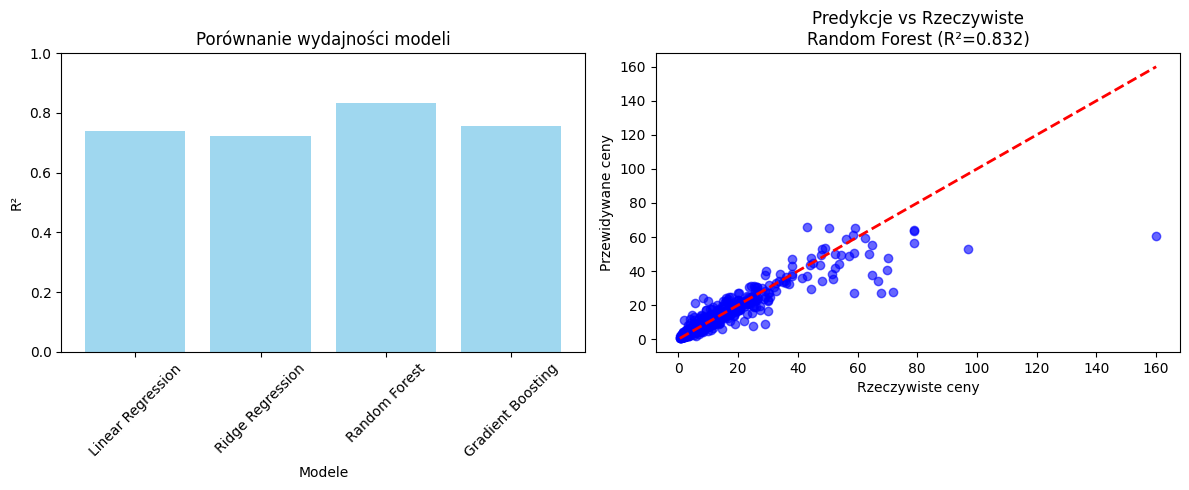

Projekt predykcji cen samochodów zakończony!


In [10]:
# Wizualizacja wyników
if 'results' in locals() and len(results) > 0:
    plt.figure(figsize=(12, 5))
    
    # 1. Porównanie metryk modeli
    plt.subplot(1, 2, 1)
    models_names = list(results.keys())
    r2_scores = [results[name]['r2'] for name in models_names]
    
    plt.bar(models_names, r2_scores, alpha=0.8, color='skyblue')
    plt.xlabel('Modele')
    plt.ylabel('R²')
    plt.title('Porównanie wydajności modeli')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # 2. Predicted vs Actual dla najlepszego modelu
    plt.subplot(1, 2, 2)
    best_results = results[best_model_name]
    y_pred_best = best_model.predict(X_val)
    
    plt.scatter(y_val, y_pred_best, alpha=0.6, color='blue')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel('Rzeczywiste ceny')
    plt.ylabel('Przewidywane ceny')
    plt.title(f'Predykcje vs Rzeczywiste\n{best_model_name} (R²={best_results["r2"]:.3f})')
    
    plt.tight_layout()
    plt.show()
    
    print("Projekt predykcji cen samochodów zakończony!")

## 6. Podsumowanie

Projekt predykcji cen samochodów został ukończony. Porównano różne algorytmy uczenia maszynowego, najlepszy model został wybrany na podstawie metryk R², MAE i RMSE.
